<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2024/Practica_7_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 7: Inferencia estadística

En este clase vamos a dar los primeros pasos en lo que es comunmente llamado "Ajuste o calibración de modelos". Es decir, estimar parámetros de modelos de generación de datos a partir de observaciones.

A nivel general, el problema es hayar la probabilidad de que una variable $X$ tome determinado valor $k$ (en el caso de continuas, la densidad de probabilidad) dado los datos medidos:

$$p(X= k|\mathbf{x})$$

Noten, es una probabilidad **condicionada a los datos medidos**

Para eso, tenenemos que **proponer** un modelo para los datos. ¿Vendrán de una Normal? ¿Una Poisson? ¿Una Gumbel? Este modelo de datos se identifica como (por ejemplo, para una Poisson):

$$X \sim Poisson(\lambda)$$

Es decir que, en mi modelo, la probabilidad de que $X$ tome un valor $k$ **dado** $\lambda$ es:

$$p(X=k|\lambda)=\frac{\lambda^{k}e^{-\lambda}}{k!}$$

También es una probabilidad **condicionada al parámetro**

La pregunta es, entonces, ¿cómo encuentro lo primero? Bueno, primero, recordando que:

$$p(X=\mathbf{x}|\lambda)=\prod_{i=1}^{n_{x}} \frac{\lambda^{x_{i}}e^{-\lambda}}{x_{i}!}$$

Es decir, la probabilidad de los datos dado el parámetro es el producto de las probabilidades de cada uno (son independientes). Y, después, que el teorema de Bayes me permite **invertir** la condicionalidad:

$$p(\lambda|\mathbf{x}) = \frac{p(X=\mathbf{x}|\lambda)\ p(\lambda)}{\int p(X=\mathbf{x}|\lambda)\ p(\lambda)\ d\lambda}$$

Noten, entonces, que uno puede obtener entonces **la función de distribución de probabilidad del parámetro de mi modelo** condicionada a los datos medidos en función de 2 cosas:
1. La verosimilitud (la información que me dan los datos)
2. Mi conocimiento a priori del parámetro (lo que se antes de tener datos)

El denominador pueden pensarlo simplemente como una constante de integración necesaria para que me quede una función de densidad (con área unitaria).

¿Qué es lo que tengo entonces?

1. Propuse un modelo de donde vinieron los datos, lo que derivó en una función de Verosimilitud (la probabilidad de que los datos vengan de ese modelo con ese parámetro)
2. Propongo o tengo un conocimiento a priori del parámetro (transmitido a través de una función de distribución a priori)

¿Y a qué llego?

1. A una función de distribución posterior de los parámetros del modelo, aplicando el teorema de Bayes.

¿Qué faltaría? Encontrar finalmente el modelo para **predecir futuras observaciones**. Por el teorema de probabilidad total, esto resulta:

$$p(X= k|\mathbf{x}) = \int p(X=k|\lambda)\ p(\lambda|\mathbf{x})\ d\lambda$$

Obviamente, uno lo ve así y le dan un poco de miedo todas estas integrales. Pero no se preocupen, porque:
1. Algunos problemas sencillos tienen soluciones analíticas para las distribución posterior y predictiva
2. La simulación permite resolver las integrales "bastante fácil"
3. ¡A lo largo del curso usaremos librerías que lo van a hacer todo por nosotros!


**Nota adicional**: La distribución de Poisson puede escribirse también en función del intervalo de tiempo estudiado, ya que es arbitrario. Es decir, yo puedo analizar "Sismos por año" o "Sismos cada 50 años" para el mismo fenómeno. Entonces, fijando el intervalo de tiempo $\Delta t$ nos queda que:

$$p(X=k|\lambda,\Delta t)=\frac{\left(\lambda\, \Delta t\right)^{k}e^{-\left(\lambda\, \Delta t\right)}}{k!}$$

cuyo valor medio es $\bar{x}=\lambda\, \Delta t$, un valor adimensional (el conteo de eventos).

## Ejemplo: Sismos en San Juan (soluciones analíticas)

El primer ejemplo que vamos a seguir es el ajuste de un modelo para predecir el número de sismos en la Provincia de San Juan por año. La pregunta que queremos contestar es:

- ¿Cuál es la probabilidad de que no haya un sismo de moderada magnitud en los próximos 5 años?

Para ello, descargamos de la página de [USGS](https://earthquake.usgs.gov/earthquakes/search/), los datos de los últimos 80 años.

### Limpieza de los datos (Off Road)

Para el que le interesa, a continuación les dejamos todo el proceso de convertir los datos descargados en algo "útil" para trabajar, tema que excede largamente a los objetivos del curso.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

from google.colab import files

In [2]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
uploaded = files.upload()

Saving Sismos_SanJuan.csv to Sismos_SanJuan.csv


In [3]:
#Se crea un DataFrame
df_sismos = pd.read_csv(io.BytesIO(uploaded['Sismos_SanJuan.csv']))
df_sismos.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-12-27T13:01:04.080Z,-31.2940,-69.3336,109.05,4.5,mb,NaN,66.0,0.609,0.77,...,2022-03-05T23:10:45.040Z,"9 km ENE of Calingasta, Argentina",earthquake,4.6,5.8,0.314,3.0,reviewed,us,us
1,2021-12-08T23:36:02.742Z,-31.8741,-68.3598,112.11,4.0,mb,NaN,115.0,0.288,1.04,...,2022-02-12T23:07:04.040Z,"22 km S of Nueve de Julio, Argentina",earthquake,8.2,4.3,0.184,8.0,reviewed,us,us
2,2021-11-25T03:18:30.863Z,-32.7200,-70.1864,112.84,4.0,mb,NaN,109.0,0.310,0.43,...,2022-01-29T22:55:53.040Z,"40 km ENE of Los Andes, Chile",earthquake,2.7,8.1,0.298,3.0,reviewed,us,us
3,2021-11-18T01:09:40.958Z,-31.2685,-69.0364,106.72,4.5,mb,NaN,47.0,0.408,0.65,...,2022-01-22T20:52:00.040Z,"37 km ENE of Calingasta, Argentina",earthquake,5.8,5.4,0.140,15.0,reviewed,us,us
4,2021-11-03T03:17:48.635Z,-32.6971,-70.0638,100.25,5.7,mww,NaN,18.0,0.415,0.77,...,2022-01-14T17:58:56.040Z,Chile-Argentina border region,earthquake,4.6,1.3,0.041,58.0,reviewed,us,us


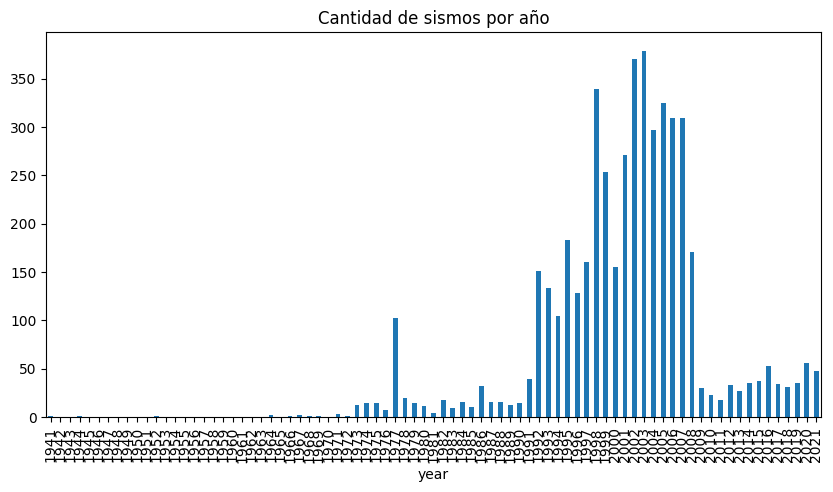

In [4]:
# Convertir a datetime
df_sismos['time'] = pd.to_datetime(df_sismos['time'])

# Conteo por año
Data = df_sismos.groupby(pd.Grouper(key='time', freq='YE')).count().reset_index()
Data['year'] = Data['time'].dt.year

# Grafico
Data.plot(x='year', y='mag',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

¿Notan algo raro? ¿Cómo puede ser que haya explotado el número de sismos de repente?

Acá es donde entra en juego el conocimiento del fenómeno físico. Uno ve los datos de arriba y se ven claramente cuatro grandes regiones: Una hasta el 73, otra hasta el 92 y un último quiebre en la información en 2008.

Esto no es porque la sismicidad de San Juan haya cambiado significativamente en estos 50 años, sino que es una consecuencia de los cambios en la instrumentación de la región y los sismos que se informan y recolecta USGS.

Una forma fácil de chequear que el dataset así como está no sigue una distribución de poisson es si $\mu\not=\sigma^2$ (es una propiedad de la misma).

In [5]:
# Chequear media y varianza
mu1 = df_sismos['time'].groupby(df_sismos["time"].dt.year).count().mean()
s1 = df_sismos['time'].groupby(df_sismos["time"].dt.year).count().var()
print('media',mu1)
print('varianza',s1)

media 83.10169491525424
varianza 12497.851548801871


¡Nada que ver! Pero esperá... pensemos cómo limpiar los datos.

1. Los datos anteriores a 1974 están claramente incompletos (no había datos)
2. Vamos a quedarnos sólo con los sismos "grandes" (mayores a Magnitud 5), porque los otros no se solían informar.

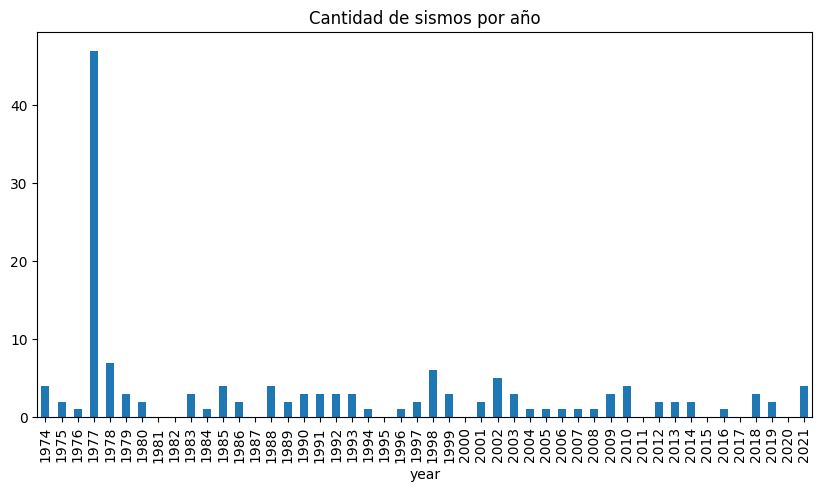

media 3.717948717948718
varianza 52.628879892037816


In [6]:
## Filtrar datos anteriores a 1973 y con M < 5
Filter = (df_sismos['time']>pd.Timestamp('1974-01-01',tz='GMT+0'))*(df_sismos['mag']>5.)
df_sismosF = df_sismos[Filter]

# Conteo por año
Data = df_sismosF.groupby(pd.Grouper(key='time', freq='YE')).count().reset_index()
Data['year'] = Data['time'].dt.year

# Grafico
Data.plot(x='year', y='mag',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

# Chequear media y varianza
mu1 = df_sismosF['time'].groupby(df_sismosF["time"].dt.year).count().mean()
s1 = df_sismosF['time'].groupby(df_sismosF["time"].dt.year).count().var()
print('media',mu1)
print('varianza',s1)

¡Mejor! Pero sigue sin parecerse a una Poisson.

¿Pero no notan algo raro? ¿Qué pasó en San Juan en 1977?

¡Claro! El sismo de Caucete. Lo que estoy viendo ahí son **todas las réplicas**. Esos eventos no son independientes, tengo que eliminarlos. ¿Cómo?

Como este no es un curso de análisis sísmico, no entraremos al detalle de como filtrar el dataset, pero pueden encontrarlo en Gardner and Knopoff (1974). En resumen, se mira un ventana espacio-temporal que es función de la magnitud para generar un cluster de sismos, y aquel de mayor magnitud es el evento principal y resto son réplicas, eliminandose del dataset.

**Gardner, J. K., & Knopoff, L. (1974). Is the sequence of earthquakes in Southern California, with aftershocks removed, Poissonian?. Bulletin of the seismological society of America, 64(5), 1363-1367.*

In [7]:
# Gardner Knopoff (1974)

# Distancia en base a latitud y longitud de 2 puntos
def distance_d(LaA, LaB, LoA, LoB):
  # Pasar a Radianes
  LoA = np.radians(LoA)
  LoB = np.radians(LoB)
  LaA= np.radians(LaA)
  LaB = np.radians(LaB)
  # "Haversine formula"
  D_Lo = LoB - LoA
  D_La = LaB - LaA
  P = np.sin(D_La / 2)**2 + np.cos(LaA) * np.cos(LaB) * np.sin(D_Lo / 2)**2
  Q = 2 * np.arcsin(np.sqrt(P))
  # Radio de la tierra en km
  R_km = 6371

  # Distancia en km
  return(Q * R_km)

# Valores de distancia y tiempo limites para chequear eventos
from scipy.interpolate import interp1d
M = np.linspace(2.5,8.0,12)
Tval = np.array([6,11.5,22,42,83,155,290,510,790,915,960,985])
Rval = np.array([19.5,22.5,26,30,35,40,47,54,61,70,81,94])

# Interpolacion lineal para otras magnitudes
Tthre = interp1d(M,Tval)
Rthre = interp1d(M,Rval)

# Inicializar una nueva columna que indique si es Main Shock (1) o no (2)
df_sismos['Main'] = np.zeros(df_sismos.shape[0])
# Iterar sobre los sismos
for i in range(df_sismos.shape[0]):
  # Chequear que no haya sido descartado por otra ventana
  if df_sismos['Main'][i] != 2:
    Mi = df_sismos['mag'][i] # Magnitud del sismo
    Ti = Tthre(Mi) # Ventana de tiempo
    Ri = Rthre(Mi) # Radio a considerar

    # Encontrar todos los sismos dentro de la ventana espacio-temporal
    Time = df_sismos['time'][i] # Dia del sismo i
    DeltaT = df_sismos['time'] - Time # Tiempo entre sismos
    DeltaT = DeltaT.dt.days # Tiempo en dias

    # Latitudes y Longitudes
    LaA = df_sismos['latitude'][i]
    LaB = df_sismos['latitude']
    LoA = df_sismos['longitude'][i]
    LoB = df_sismos['longitude']

    # Distancia entre epicentros
    Dist = distance_d(LaA,LaB,LoA,LoB)

    # Sismos a chequear
    FiltCheck = (np.abs(DeltaT)<Ti)*(Dist<Ri)

    # Verificar que califica como Main Shock
    if (Mi>=df_sismos['mag'][FiltCheck]).all() == True:
      # Descartar Cluster
      df_sismos.loc[FiltCheck,'Main'] = 2
      # Definir Main Shock
      df_sismos.loc[i,'Main'] = 1

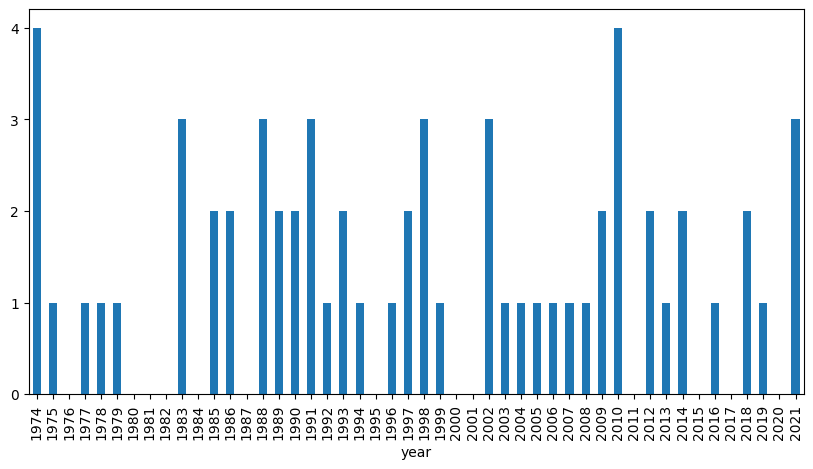

media 1.3125
varianza 1.2832446808510638


In [8]:
# Definir Dataset filtrado final
FinalF = (df_sismos['Main'] == 1)*(df_sismos['mag']>5)*(df_sismos['time']>pd.Timestamp('1974-01-01',tz='GMT+0'))
df_sismosFinal = df_sismos[FinalF]

# Conteo por año
Data = df_sismosFinal.groupby(pd.Grouper(key='time', freq='YE')).count().reset_index()
Data['year'] = Data['time'].dt.year

# Grafico
Data.plot(x='year', y='mag',kind='bar',yticks=[0,1,2,3,4], legend=False, figsize=(10,5))
#plt.title('xx')
plt.show()

# Chequear media y varianza
mu1 = Data['mag'].mean()
s2 = Data['mag'].var()
print('media',mu1)
print('varianza',s2)

Miren ahora como en 1977 en realidad solo hubo 1 sismo independiente. ¡Los otros 39 eran réplicas de ese!

Y noten ahora como estos datos filtrados efectivamente cumplen con una de las propiedades de la distribución de Poisson.

¡Nos faltaría chequear nada más que son independientes!

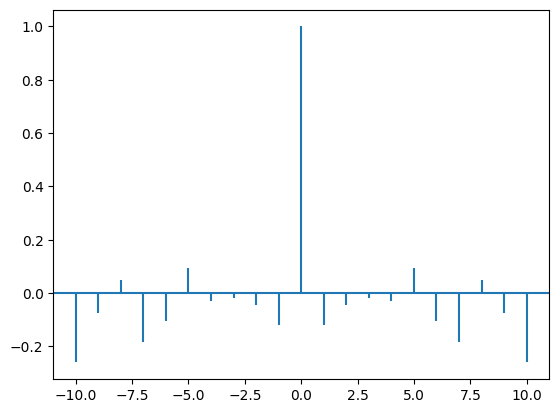

In [9]:
# Autocorrelación
plt.acorr( Data['mag']-Data['mag'].mean() );

¡Efectivamente lo son! (o pareciera). Así que decir que el modelo que generó los datos es una distribución de Poisson es razonable.

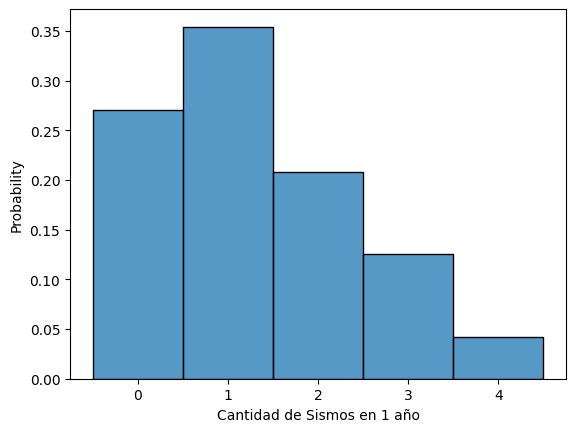

In [10]:
sns.histplot(Data['mag'],label='Sismos por año',stat='probability',discrete=True)
#plt.legend()
plt.xlabel('Cantidad de Sismos en 1 año')
plt.show()

### Modelo analítico

Los modelos de Poisson tienen solución análítica siempre y cuando se tome como distribución a priori una distribución Gamma (es una distribución a priori conjugada). Es decir, que si:

$$p(X=k|\lambda)=\frac{\lambda^{k}e^{-\lambda}}{k!}$$

y adopto como distribución a priori:

$$\lambda \sim \Gamma(\alpha, \beta)$$

Entonces la distribución posterior de $\lambda
$ será:

$$\lambda|\mathbf{x} \sim \Gamma(\alpha^{\prime}, \beta^{\prime})$$

Donde:

- $\alpha^{\prime}=\alpha+\sum_{i=1}^{n_{x}} x_{i}$ (Le sumo el total de eventos ocurridos).
- $\beta^{\prime} = \beta+\sum_{i=1}^{n_{x}} i$ (Le sumo el total de intervalos analizados).

**Nota:** Puedo tener 50 datos de un año (si quiero calibrar sismos por año), o 1 dato de 50 años (si quiero calibrar sismos en 50 años). **Es lo mismo a fines prácticos**. Es más, los datos ni siquiera tienen que ser tomados en intervalos uniformes, sólo importa la suma total de eventos e intervalos para la inferencia.

A su vez, la predición de nuevos datos queda dada por:

$$X|\mathbf{x} \sim NB\left(\alpha^{\prime},\frac{\beta^{\prime}}{1+\beta^{\prime}}\right)$$

Es decir, una [Binomial Negativa](https://en.wikipedia.org/wiki/Negative_binomial_distribution)

#### Parámetros necesarios de los datos

Fijensé que tenemos todo! Primero, anotemos lo que necitamos extraer de los datos:

In [11]:
# Numero de intervalos
sum_DT = len(Data)
print('El intervalo total es',sum_DT,'años')

# Cantidad de sismos totales
sum_xi = np.sum(Data['mag'])
print('La cantidad de sismos en el tiempo medido es',sum_xi)

El intervalo total es 48 años
La cantidad de sismos en el tiempo medido es 63


Y definamos, por ejemplo, que yo quiero el dato de sismos por año.

#### Definición de los parámetros de la distribución a priori

Una distribución Gamma de parámetros $\alpha$ y $\beta$

$$y \sim \Gamma(\alpha, \beta)$$

se caracteriza por:

- un valor medio $\bar{y}=\frac{\alpha}{\beta}$
- un desvío estandar $\sigma_{y}=\frac{\sqrt{\alpha}}{\beta}$

$\alpha$ y $\beta$ terminan representando en cierta forma la cantidad de eventos y el tiempo evaluado respectivamente en la distribución posterior. Por lo tanto, podemos explotar esa idea para incorporar conocimiento previo de $\lambda$.

Por ejemplo, si yo me imagino que en San Juan (antes de ver los datos) la cantidad de sismos debe estar razonablemente entre 0.5 y 4.5 sismos al año. Es decir, podría pensar a priori en una variable aleatoria con valor medio $\bar{y}=2.5$ y desvío estandar $\sigma_{y}=1$. Resolviendo el sistema de ecuaciones esto implica:

- $\beta = \frac{\bar{y}}{\sigma_{y}^{2}}=2.5$
- $\alpha = \bar{y}\beta=6.25$

Noten que lo que estoy diciendo en cierta forma es que yo a priori estoy asumiendo que vería o vi el equivalente 6.25 sismos en 2.5 años. ¡Y con esto ya tengo todos los datos para seguir!

Este tal vez es el punto más "dificil" a veces. Recuerden que la distribución a priori es la representación de lo que *nosotros* pensamos que es. En general, no sabemos nada... En esos casos dejamos "que los datos nos hablen", usando distribuciones a priori no-informativas.

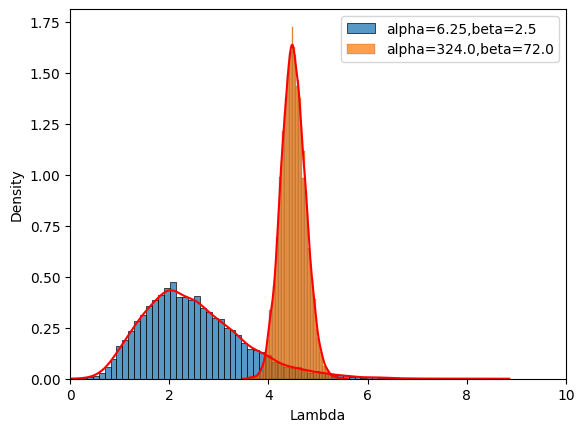

In [12]:
rng = np.random.default_rng()
N = 10000

# Distribucion Gamma
alpha1 = 6.25
beta1 = 2.5
l_sim1 = rng.gamma(alpha1,1/beta1,N)

alpha2 = 4.5**2/0.25**2
beta2 = 4.5/0.25**2
l_sim2 = rng.gamma(alpha2,1/beta2,N)

sns.histplot(l_sim1,stat='density',label='alpha='+str(alpha1)+',beta='+str(beta1))
sns.kdeplot(l_sim1,color='red')
sns.histplot(l_sim2,stat='density',label='alpha='+str(alpha2)+',beta='+str(beta2))
sns.kdeplot(l_sim2,color='red')
plt.xlabel('Lambda')
plt.legend()
plt.xlim([0,10])
plt.show()

Como ven, $\beta$ controla la dispersión de la función, a tal punto que si $\beta \rightarrow 0$ el desvío se vuelve infinito, que sería una priori completamente no-informativa. Estas distribuciones son impropias, es decir que no son verdaderas funciones de distribución (su área no es unitaria), pero sirven matemáticamente para hallar soluciones analíticas.

Se puede demostrar (y se ve en el gráfico) que si $\alpha = 1$ y $\beta → 0$ la distribución tiende a ser constante para todo valor no-negativo de $\lambda$. Es decir, le estaría asignando igual probabilidad a todos los valores posibles de $\lambda$.

$$p(\lambda) ∝ 1$$

Qué tan razonable es eso los dejo a su criterio (si me preguntan a mi, no es lógico pensar que la cantidad de sismos por año puede ser infinito o 3 con igual probabilidad)

A su vez, antes dijimos que $\alpha$ y $\beta$ puedo pensarlo como los sismos y la cantidad de años (mi confianza en el dato) que imagino antes de ver las mediciones. Entonces, ¿cómo podríamos decir que "no vimos nada"? Es decir, alguna otra forma de decir que no tenemos información a priori. Podríamos pensar que "a priori" vimos 0 sismos en 0 años. Eso nos lleva a considerar $\alpha\rightarrow 0$ y $\beta \rightarrow 0$, lo cual se puede demostrar tiene la forma

$$p(\lambda) ∝ \frac{1}{\lambda}$$

Como no son verdaderas funciones de distribución y tienen dispersión muy grande estas no se pueden simular. Abajo se muestran soluciones analíticas (obtenidas con `scipy.stats`) para valores muy pequeños de $\beta$, para que tengan referencia

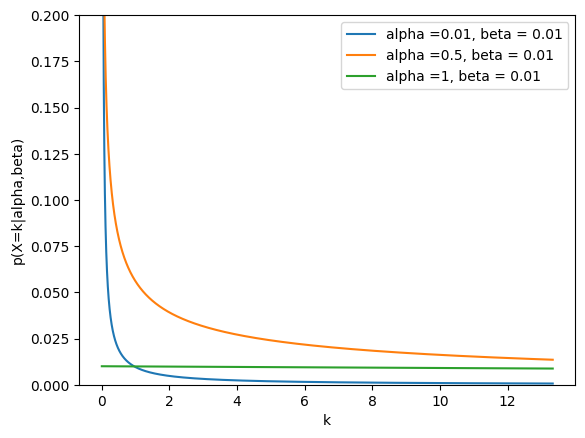

In [13]:
# Soluciones analiticas
# ==============================================================================
import scipy.stats as st

alpha = [0.01, 0.5, 1]
beta = [0.01]

ki = np.array(range(10000))/750
for ai in alpha:
  for bi in beta:
    model = st.gamma(ai,scale=1/bi)
    pm = model.pdf(ki)
    name = 'alpha ='+str(ai)+', beta = '+str(bi)
    plt.plot(ki,pm,label=name)

plt.ylim([0,0.2])
plt.legend()
plt.xlabel('k')
plt.ylabel('p(X=k|alpha,beta)')
plt.show()
# ==============================================================================


#### Evaluación de las distribuciones a priori

No siempre es fácil entender cómo influyen nuestras prioris en el resultado final, o mismo si efectivamente están transmitiendo la información que nosotros queríamos introducir o no. Esto ocurre especialmente en problemas multivariados.

Una forma de ver qué están haciendo es resolver el modelo si no tuviese datos. Es decir, asumiendo:

- $\alpha^{\prime}=\alpha+\sum_{i=1}^{n_{x}} x_{i} = \alpha$
- $\beta^{\prime} = \beta+\sum_{i=1}^{n_{x}} i = \beta$

Por lo que la predición de nuevos datos queda dada por:

$$X|\mathbf{x} \sim NB\left(\alpha,\frac{\beta}{1+\beta}\right)$$

El objetivo es ver si las prioris resultan en valores de la variable $X$ razonables para lo que nosotros queríamos (que no simule 1,000,000 de sismos al año por ejemplo, o que de valores negativos, etc.). También miramos si la dispersión es razonable o estamos introduyendo demasiado información.

Este análisis lo puedo hacer de dos maneras:
1. Directamente con solución analítica de posterior predictiva (si la hay)
2. Simulando en forma jerárquica. Es decir, primero simulo valores de $\lambda$ con la distribución posterior, y después uso esos valores valores para simular los sismos por año

Esta segunda forma me permite de cierta forma generar réplicas de mi ensayo. Es decir, si vi 48 años de datos, puedo simular grupos de 48 datos, cada uno de ellos con $\lambda$ distinto que surge de la simulación de la posterior. La ventaja es que puedo ver no sólo el promedio, sino la variación que puedo esperar al ver los datos.

Abajo pueden verlo resuelto de ambas maneras

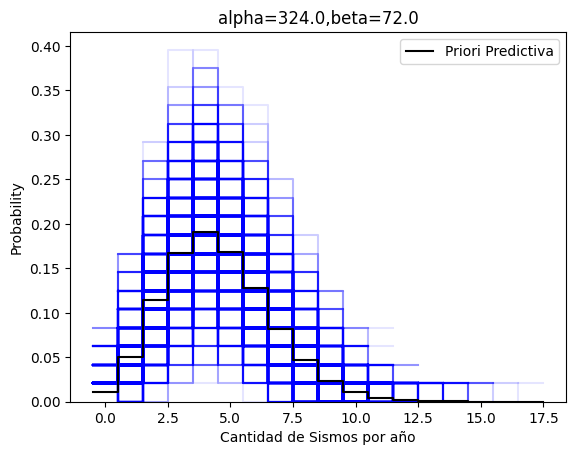

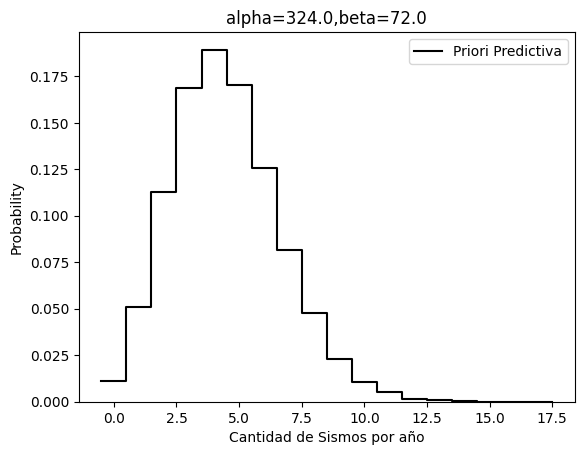

In [14]:
# Simulacion con Numpy (Jerarquico)
N1 = 2000 # Simulo 2000 veces los parametros
N2 = 48 # Para cada parametro simulo 48 datos (replica de mis datos)
lam_sim = rng.gamma(alpha2,1/beta2,(N1,1)) # Simulo Lambda
Y_sim = rng.poisson(lam_sim,(N1,N2)) # Simulo sismos/ano dado lambda

for i in range(N1):
  sns.histplot(Y_sim[i,:], discrete=True,stat='probability',element="step",
               fill=False,alpha=0.1,legend=False,color='blue',label=None)
sns.histplot(np.ravel(Y_sim), discrete=True,stat='probability',element="step",
             fill=False,legend=False,color='black',label='Priori Predictiva')
plt.legend()
plt.xlabel('Cantidad de Sismos por año')
plt.title('alpha='+str(alpha2)+',beta='+str(beta2))
plt.show()

# Simulación con Numpy (Directo)
Y_sim2 = rng.negative_binomial(alpha2,beta2/(1+beta2),N1*N2)

sns.histplot(Y_sim2, discrete=True,stat='probability',element="step", fill=False,
             legend=False,color='black',label='Priori Predictiva')
plt.legend()
plt.xlabel('Cantidad de Sismos por año')
plt.title('alpha='+str(alpha2)+',beta='+str(beta2))
plt.show()

#### Distribución posterior

Una vez que definí la distribución a priori y vi que funciona como yo quiero, procedo a resolver el ejercicio. Recordando, la distribución posterior de $\lambda
$ será:

$$\lambda|\mathbf{x} \sim \Gamma(\alpha^{\prime}, \beta^{\prime})$$

Donde:

- $\alpha^{\prime}=\alpha+\sum_{i=1}^{n_{x}} x_{i}$ (Le sumo el total de eventos ocurridos).
- $\beta^{\prime} = \beta+\sum_{i=1}^{n_{x}} i$ (Le sumo el total de intervalos analizados).

¡Simplemente es simularlo ahora!

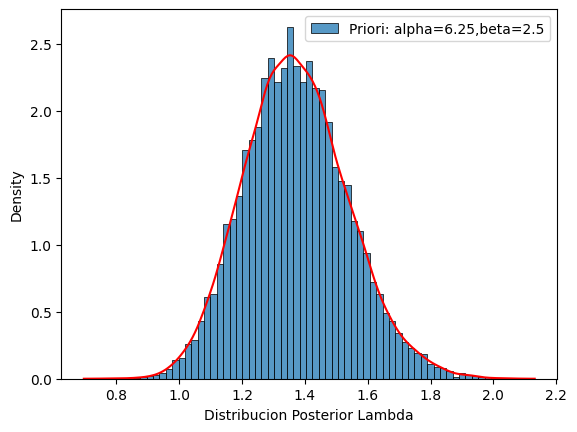

In [15]:
rng = np.random.default_rng()
N = 10000

alpha1 = 6.25
beta1 = 2.5
l_sim1 = rng.gamma(alpha1+sum_xi,1/(beta1+sum_DT),N)

sns.histplot(l_sim1,stat='density',label='Priori: alpha='+str(alpha1)+',beta='+str(beta1))
sns.kdeplot(l_sim1,color='red')
plt.legend()
plt.xlabel('Distribucion Posterior Lambda')
plt.show()

A continuación, mostramos la distribución posterior para todas las prioris que fuimos proponiendo en el ejercicio. Noten que siempre que se usa una priori relativamente poco informativa (ya sea las no-informativas con $\beta=0$ o la que adoptó $\alpha=6.25$, $\beta=2.5$ los resultados son básicamente idénticos. Ese es un buen indicio de que están dejando "hablar a los datos".

Puede ser entonces, una buena estrategia para evaluar la priori es mirar justamente si mis conclusiones son muy sensibles. Tengan en mente que tal vez uno quería introducir información (porque tiene pocos datos, u otras fuentes de datos), no significa que está mal.

El caso con $\alpha=324$ y $\beta=72$ por ejemplo era una priori muy informativa ($\lambda$ entre 4 y 5). Esa priori pesa bastante, entonces los datos tiraron la campana de la posterior hacia la izquierda, pero no tanto como los otros casos. Si hubiera infinitos datos, todas terminarían convergiendo.

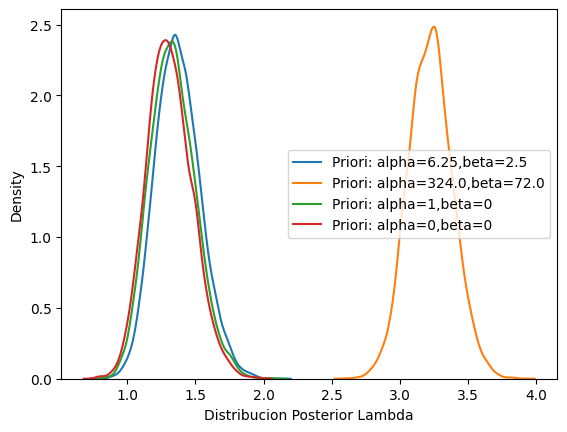

In [16]:
rng = np.random.default_rng()
N = 10000

alphaV = [6.25, 4.5**2/0.25**2, 1, 0]
betaV = [2.5, 4.5/0.25**2, 0, 0]

for i in range(len(alphaV)):
  l_simV = rng.gamma(alphaV[i]+sum_xi,1/(betaV[i]+sum_DT),N)
  sns.kdeplot(l_simV,label='Priori: alpha='+str(alphaV[i])+',beta='+str(betaV[i]))
plt.legend()
plt.xlabel('Distribucion Posterior Lambda')
plt.show()

#### Distribución posterior predictiva

Continuando con la obtención de resultados de la inferencia, puedo sacar también la predición de nuevos datos con lo anterior. Recordando, teníamos que:

$$X|\mathbf{x} \sim NB\left(\alpha^{\prime},\frac{\beta^{\prime}}{1+\beta^{\prime}}\right)$$

Puedo directamente simular esto...

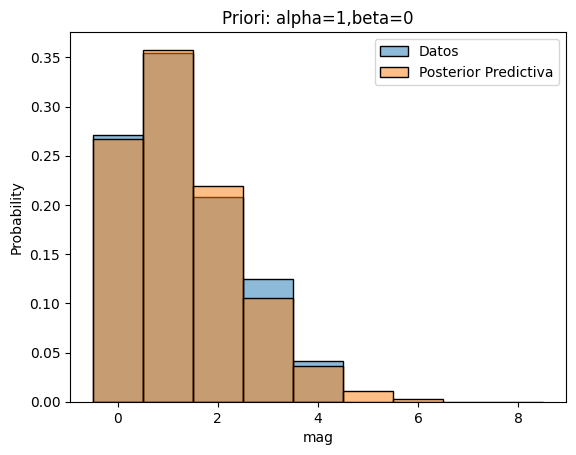

In [17]:
# Simulo NB de una
N = 4800

alpha1 = 1
beta1 = 0
X_sim = rng.negative_binomial(1+sum_xi,sum_DT/(1+sum_DT),N)

sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',alpha=0.5)
sns.histplot(X_sim,discrete=True,stat='probability',label='Posterior Predictiva',alpha=0.5)
plt.legend()
plt.title('Priori: alpha='+str(alpha1)+',beta='+str(beta1))
plt.show()

Y compararlo contra los datos. Es decir, ver si el histograma de mis simulaciones de nuevas observaciones se parece al historgrama de datos.

Como comentario, no necesariamente tienen que ser iguales (a fin de cuentas, yo tengo sólo una muestra, no toda la población). Acá es donde se vuelve interesante hacer la simulación jerarquica que vimos antes. Al simular grupos de 48 datos (mismo tamaño que mi dataset), me permite ver no sólo la posterior predictiva sino también los histogramas de estas distintas réplicas. Puedo reconocer entonces, si el histograma de mis datos es una realización probable con mi modelo, y ya no sólo comparar contra el promedio. Entra en juego ya la variabilidad propia del experimento para evaluar.

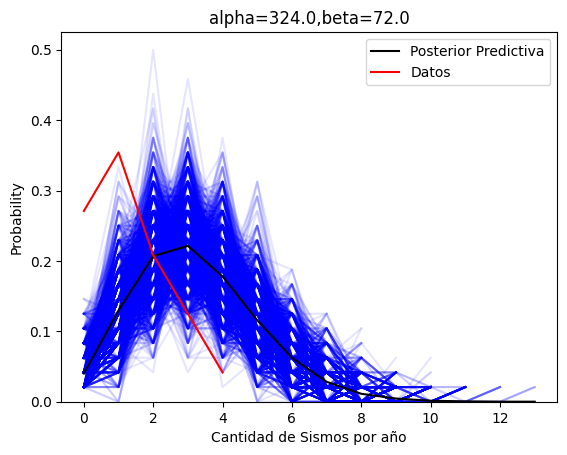

In [18]:
# Simulacion con Numpy (Jerarquico)
N1 = 2000 # Simulo 2000 veces los parametros
N2 = 48 # Para cada parametro simulo 48 datos (replica de mis datos)
alpha1 = 4.5**2/0.25**2
beta1 = 4.5/0.25**2
lam_sim = rng.gamma(alpha1+sum_xi,1/(beta1+sum_DT),(N1,1)) # Simulo Lambda
Y_sim = rng.poisson(lam_sim,(N1,N2)) # Simulo sismos/ano dado lambda

for i in range(N1):
  sns.histplot(Y_sim[i,:], discrete=True,stat='probability',element="poly",
               fill=False,alpha=0.1,legend=False,color='blue',label=None)
sns.histplot(np.ravel(Y_sim), discrete=True,stat='probability',element="poly",
             fill=False,legend=False,color='black',label='Posterior Predictiva')
sns.histplot(Data['mag'], discrete=True,stat='probability',element="poly",
             fill=False,legend=False,color='red',label='Datos')
plt.legend()
plt.xlabel('Cantidad de Sismos por año')
plt.title('alpha='+str(alpha1)+',beta='+str(beta1))
plt.show()

Por ejemplo, con $\alpha=6.25$, $\beta=2.5$ se ve que los datos se parecen a la posterior predictiva, y fundamentalmente que cae dentro del abánico de posibilidades si yo sacase 48 datos de mi modelo ajustado. Mientras tanto, veo que con $\alpha=324$ y $\beta=72$ mis datos son una realización prácticamente imposible de mi modelo, lo que implica que no es un buen ajuste (en este caso, culpa de mi priori exagerada...)

#### Uso del modelo (Contestar preguntas)

Todo esto lo hicimos con una razón: contestar nuestra pregunta original.

- ¿Cuál es la probabilidad de que no haya un sismo de moderada magnitud en los próximos 5 años?

Para contestar la pregunta no vamos a usar los datos directamente, sino el modelo que construimos con ellos. Generando simulaciones (miles de años de datos generados), podemos contestar.

La pregunta la podemos contestar de dos maneras, una, usando algún conocimiento de probabilidad y estádistica. Es decir, que la probabilidad de que no haya sismos durante 5 años es:

$$P50 = p(X=0|\mathbf{x})^{5}$$

ya que para que no haya sismos en 5 años no puede ocurrir en ningún año y cada año es independiente entre sí.

In [19]:
# Simulo NB de una
N = 100000

alpha1 = 1
beta1 = 0
X_sim = rng.negative_binomial(1+sum_xi,sum_DT/(1+sum_DT),N)

# Probabilidad de 0 sismos en 1 año
P0 = np.mean(X_sim==0)
print('Probabilidad de 0 sismos en 1 año:',round(P0,3))

# Probabilidad de 0 sismos en 5 años
P5 = np.mean(X_sim==0)**5
print('Probabilidad de 0 sismo en 5 año:',round(P5,5))

Probabilidad de 0 sismos en 1 año: 0.269
Probabilidad de 0 sismo en 5 año: 0.0014


Otra forma de hacerlo es literalmente simulando el problema en su conjunto. Simulo miles de grupos de 5 años, y me fijo en cuántos grupos de 5 años no hubo sismos.

Puedo hacer este proceso, por ejemplo, en forma jerárquica si quiero:

In [20]:
# Simulacion con Numpy (Jerarquico)
N1 = 100000 # Simulo N veces los parametros
N2 = 5 # Para cada parametro simulo 5 datos
alpha1 = 1
beta1 = 0
lam_sim = rng.gamma(alpha1+sum_xi,1/(beta1+sum_DT),(N1,1)) # Simulo Lambda
Y_sim = rng.poisson(lam_sim,(N1,N2)) # Simulo sismos/ano dado lambda

# Probabilidad de 0 sismos en 1 año
P0 = np.mean(np.ravel(Y_sim)==0)
print('Probabilidad de 0 sismos en 1 año:',round(P0,3))

# Probabilidad de 0 sismos en 5 años
P5 = np.mean(np.sum(Y_sim,axis=-1)==0)
print('Probabilidad de 0 sismo en 5 año:',round(P5,5))

Probabilidad de 0 sismos en 1 año: 0.267
Probabilidad de 0 sismo en 5 año: 0.00151


Resultado que da casi igual. Tengan en cuenta que la probabilidad es muy muy baja y para cuantiles muy chicos o muy grandes la cantidad de simulaciones necesarias para obtener una buena estimación crece enormemente (se lo dejamos a ustedes).

## Ejercicio 1: Jugando con probabilidad y simulaciones (Ayuda para TP2)

Para cerrar, me gustaría que usemos los datos simulados del modelo ajustado para contestar algunas preguntas con Monte Carlo.

Retomemos las simulaciones que hicimos para $\lambda$ y $X$.

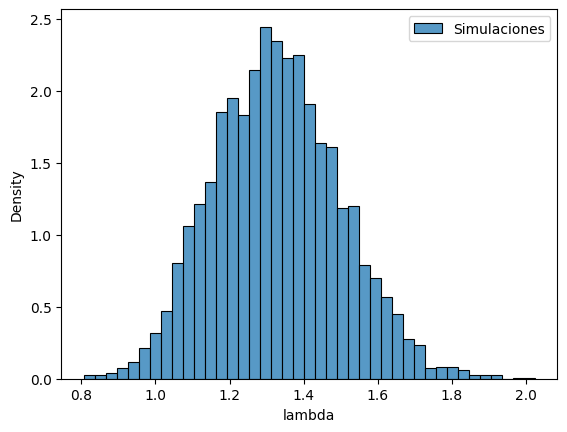

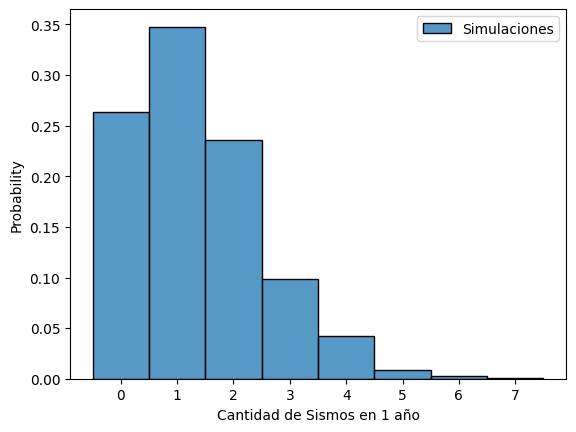

In [21]:
# Simulacion con Numpy
N = 4000
lam_sim = rng.gamma(1+sum_xi,1/sum_DT,N)
X_sim = rng.negative_binomial(1+sum_xi,sum_DT/(1+sum_DT),N)

sns.histplot(lam_sim,label='Simulaciones',stat='density')
plt.legend()
plt.xlabel('lambda')
plt.show()

sns.histplot(X_sim,label='Simulaciones',stat='probability',discrete=True)
plt.legend()
plt.xlabel('Cantidad de Sismos en 1 año')
plt.show()

Me gustaría que contestemos las siguientes preguntas.

1. ¿Cuál es la probabilidad de que haya más de 1 sismo en 1 año?
2. ¿Cuál es la probabilidad de que no haya sismos en los próximos 5 años?
3. ¿Cuál es la probabilidad de que $\lambda\leq1$
4. ¿Cuál es el percentil 90% de $\lambda$?
5. ¿Cuál es la probabilidad de que $\lambda\leq1$ dado que no se registraron sismos en un año?
6. Construya la funciones de probabilidad acumulada para ambos casos.

Recuerden, ¡son todos problemas de conteo como vimos la clase pasada!

Solucion 1: 0.389
Solucion 2: 0.0012642760162114187
Solucion 3: 0.0195
Solucion 4: 1.5493977846199976
Solucion 5: 0.015194681861348529


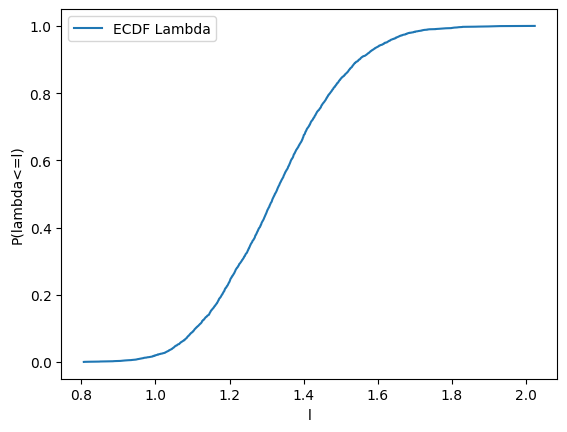

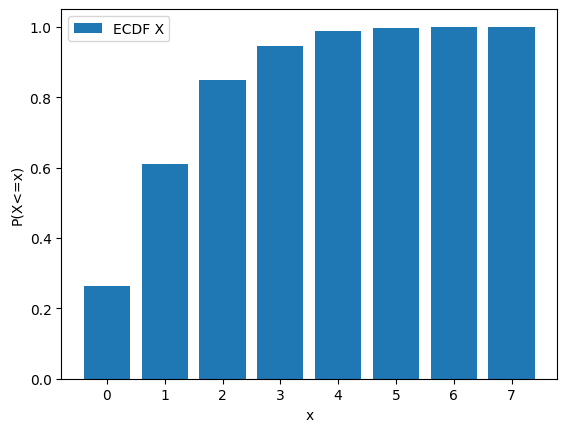

In [22]:
# Solucion 1: Cuento cuántas veces
S1 = np.mean(X_sim>1)
print('Solucion 1:',S1)

# Solucion 2: para que no haya sismos en 5 años no puede haber sismos en ningun año (son independientes)
S2 = np.mean(X_sim==0) # probabilidad que no haya sismos en 1 ano
S2 = S2**5 # me tiene que pasar 5 anos seguidos
print('Solucion 2:',S2)

# Solución 3: Conteo
S3 = np.mean(lam_sim<=1)
print('Solucion 3:',S3)

# Solución 4: Me construyo la probabilidad acumulada
# Ordeno valores
l_sort = np.sort(lam_sim)
# Calculo la p(lam<=l_sort)
l_ECDF = np.array([np.mean(lam_sim<=li) for li in l_sort])
# Hallo el valor que cumple
S4 = np.min(l_sort[l_ECDF>=0.9])
print('Solucion 4:',S4)

# Solución 5: Es un conteo acotado a la condicion
# Subselecciono simulaciones
sel = X_sim==0
# Hago el conteo dentro de la seleccion
S5 = np.mean(lam_sim[sel]<=1)
print('Solucion 5:',S5)

# Solucion 6: Curva empirica (hago la que me falta)
X_sort = np.unique(np.sort(X_sim))
X_ECDF = np.array([np.mean(X_sim<=xi) for xi in X_sort])

plt.plot(l_sort,l_ECDF,label='ECDF Lambda')
plt.xlabel('l')
plt.ylabel('P(lambda<=l)')
plt.legend()
plt.show()

plt.bar(X_sort,X_ECDF,label='ECDF X')
plt.xlabel('x')
plt.ylabel('P(X<=x)')
plt.legend()
plt.show()

## Ejercicio 2: Jugando con teoría de probabilidad y Bayes (Ayuda para TP2)
Este ejercicio (adaptado del libro de James Goulet: [Link](https://profs.polymtl.ca/jagoulet/Site/Goulet_web_page_BOOK.html)) es simple en el sentido de que su solución analítica no es más que un par de productos y divisiones, y ayuda a entender un poco más cómo funciona la inferencia estadística (y es una excusa para aplicar el Teorema de Bayes).

Supongamos que entramos en una sala de teatro en el instante $t_{0}$. En el instante $t_{1}$ Suena la alarma. ¿Cuál es la probabilidad de que haya un incendio? En un instante $t_{2}$ se puede ver humo. ¿Cuál es la probabilidad de que haya un incendio?

### Probabilidad de que haya un incendio en un instante $t_{0}$

Sin saber nada, digamos que $P(I_{t0}=1)=0.01$. De donde se desprende que $P(I_{t0}=0)=0.99$.



In [23]:
# Probabilidad de incendio en el instante t0
P_I_t0 = 0.01

### Probabilidad de que haya un incendio en un instante $t_{i+1}$

La pregunta es, ¿cómo evoluciona la probabilidad de incendio en el tiempo?

Para este ejercicio, supongamos que alguien estudió como se propagan los incendios y tenemos que:

- Si $I_{ti}=1$, entonces $P(I_{ti+1}=1|I_{ti}=1)=1$. Es decir, si había fuego hace un rato la probabilidad de que el incendio siga es 1 (no hay forma de que se apague).
- Según lo de antes, tomemos que la probabilidad que haya un incendio ahora si hace un rato no lo había es 0.01. $P(I_{ti+1}=1|I_{ti}=0)=0.01$. Es decir, no me da información nueva que antes no había un incendio porque es algo espontáneo.

De lo de arriba se desprenden los casos que faltan de probabilidad condicional:

- $P(I_{ti+1}=0|I_{ti}=0)=0.01$
- $P(I_{t1+1}=0|I_{ti}=1)=0$

In [24]:
# Probabilidad de incendio en el instante t1 dado incendio en el instante t0
P_I_t1_I_t0 = 1

# Probabilidad de incendio en el instante t1 dado NO-incendio en el instante t0
P_I_t1_NI_t0 = 0.01

### Probabilidad de que haya un incendio en un instante $t_{1}$

La pregunta entonces, ¿cómo puedo usar los datos de arriba para encontrar la probabilidad de incendio en el tiempo $t_{1}$?

Podríamos usar probabilidad total:

$$P(I_{t1}=1) = P(I_{t1}=1|I_{t0}=1)P(I_{t0}=1)+P(I_{t1}=1|I_{t0}=0)P(I_{t0}=0)$$

In [25]:
# Probabilidad de incendio en instante t1
P_I_t1 = P_I_t1_I_t0*P_I_t0 + P_I_t1_NI_t0*(1-P_I_t0)

print('La probabilidad de incendio en el instante t1 es:',P_I_t1)

La probabilidad de incendio en el instante t1 es: 0.0199


Noten que la probabilidad de incendio en el instante $t1$ es mayor al de $t0$. Es decir, cada vez es más probable que haya un incendio porque eventualmente alguno va haber y nunca se apaga. Fijense igual, que siempre que yo mire que en el instante anterior no había un incendio la probabilidad vuelve a mi caso original, como si el problema se resetease.

### Probabilidad de que haya un incendio en $t_{1}$ dado que suena la alarma (en $t_{1}$)

Imaginensé ahora que suena la alarma. ¿Cuál es la probabilidad de que haya un incendio?

Asumamos que la alarma del teatro tiene un 95% de eficacia en detectar incendios y un 5% de falsos positivos. Es decir:

- La probabilidad de alarma dado un incendio es $P(A=1|I_{ti}=1)=0.95$
- La probabilidad de alarma dado que no hay incendio es $P(A=1|I_{ti}=0)=0.05$

Nota: Es casualidad que estos datos sumen 1.

In [26]:
# Probabilidad de alarma dado incendio en t1
P_A_I_t1 = 0.95

# Probabilidad de alarma dado NO-incendio en t1
P_A_NI_t1 = 0.05

El objetivo de este problema entonces es contestar la siguiente pregunta:

*¿Cuál es la probabilidad de que haya un incendio si suena la alarma?*

Bueno, por el Teorema de Bayes esto sería:

$$P(I_{t1}=1|A=1) = \frac{P(A=1|I_{t1}=1)\ P(I_{t1}=1)}{\sum P(A=1|I_{t1}=x)\ P(I_{t1}=x)}$$

Entonces:



In [27]:
# Probabilidad de incendio en instante t1 dado que sonó la alarma
P_I_t1_A = P_A_I_t1*P_I_t1/(P_A_I_t1*P_I_t1+P_A_NI_t1*(1-P_I_t1))

print('La probabilidad de incendio en el instante t1 dado que sonó la alarma es:',P_I_t1_A)

La probabilidad de incendio en el instante t1 dado que sonó la alarma es: 0.27838315417464293


¡¡¡Es decir, suena la alarma y la chance de que realmente haya un incedio es 30%!!! Por eso ven ustedes que en general no hay mucho pánico cuando suena una alarma de incendio.




### Probabilidad de que haya un incendio en $t_{2}$ dado que sonó la alarma (en $t_{1}$)

Esto es muy parecido a lo que ya hicimos antes, podemos aplicar probalidad total. Esto será:

$$P(I_{t2}=1|A=1)=P(I_{t2}=1|I_{t1}=1)P(I_{t1}=1|A=1)+P(I_{t2}=1|I_{t1}=0)P(I_{t1}=0|A=1) $$

Donde estamos suponiendo que $P(I_{t2}=x|I_{t1}=y,A=1)=P(I_{t2}=x|I_{t1}=y)$ Es decir que la evolución de los incendios es condicionalmente independiente de la alarma, lo cual es lógico.

In [28]:
# Probabilidad de incendio en instante t2 dado que sonó la alarma
P_I_t2_A = P_I_t1_I_t0*P_I_t1_A+P_I_t1_NI_t0*(1-P_I_t1_A)

print('La probabilidad de incendio en el instante t2 dado que sonó la alarma en t1:',P_I_t2_A)

La probabilidad de incendio en el instante t2 dado que sonó la alarma en t1: 0.2855993226328965


¡Apenas superior al dato anterior!

### Probabilidad de que haya un incendio dado que ahora se ve humo en $t_{2}$

Imaginensé ahora que vemos humo en el teatro. ¿Cuál es la probabilidad de que haya un incendio?

Asumamos que se puede ver humo en el 95% de los incendios, y que si no hay incendio la probabilidad de ver humo es 5%. Es decir:

- La probabilidad de humo dado un incendio es $P(H=1|I_{ti}=1)=0.95$
- La probabilidad de humo dado que no hay incendio es $P(H=1|I_{ti}=0)=0.05$

Nota: Es casualidad que estos datos sumen 1.

In [29]:
# Probabilidad de humo dado incendio en t2
P_H_I_t2 = 0.95

# Probabilidad de humo dado NO-incendio en t2
P_H_NI_t2 = 0.05


¡Apliquemos el Teorema de Bayes otra vez! Asumiendo que el humo y la alarma no interactuan, nos queda:

$$P(I_{t2}|A=1,H=1) = \frac{P(H=1|I_{t2}=1)P(I_{t2}=1|A=1)}{\sum P(H=1|I_{t2}=x)P(I_{t2}=x|A=1)}$$

Noten que lo que estamos haciendo es invertir el orden entre las condicionales Humo e Incendio, La alarma me queda siempre como condicional. Simplifqué la nomenclatura considerando que:

$$P(H=1|I_{t2}=1,A=1)=P(H=1|I_{t2}=1)$$

Es decir, que la relación humo - incendio es condicionalmente independiente de la alarma

In [30]:
# Probabilidad de incendio en instante t2 dado que sonó la alarma y se vio humo
P_I_t2_A_H = P_H_I_t2*P_I_t2_A/(P_H_I_t2*P_I_t2_A+P_H_NI_t2*(1-P_I_t2_A))

print('La probabilidad de incendio en el instante t2 dado que sonó la alarma en t1 y se vio humo en t2 es:',P_I_t2_A_H)

La probabilidad de incendio en el instante t2 dado que sonó la alarma en t1 y se vio humo en t2 es: 0.8836630250426298


¡Ahora sí salgo corriendo! Fijensé entonces como la probabilidad de incendio se fue actualizando en función de la información. Y vean cómo este ejercicio es un simple modelito de algo que vemos a diario (nadie se asusta si suena la alarma de incendio en general porque no logra vencer la sensación de que hay pocas probabilidades de incendio, pero si además noto humo ahora siento el incendio mucho más cerca)

## Ejercicio 3: Simulación de una distribución t-student (ayuda para el TP2)

Para ayudarlos con el TP2, les dejamos aquí un ejemplo cómo simular en Numpy una distribución t-student no estandarizada. Imaginensé que tienen una Variable Aleatoria $X$ gobernada por:

$$X \sim student-t(\nu,\mu,\tau)$$

también la van a encontrar como $t_{\nu}(\mu,\tau)$

- $\nu$ se refiere a los "grados de libertad" (¿se acuerdan de Probabilidad y Estadística? Cuando $\nu→∞$ entonces la t-student se transforma en una distribución normal)
- $\mu$ es el valor medio de la distribución o factor de ubicación
- $\tau$ es el factor de escala, cumple el mismo rol que el desvío estándar en la función (dividiendo a la variable), pero eso no quiere decir *que sea igual al desvío estandar*. Eso solo ocurre cuando $\nu→∞$

El problema que tenemos es que Numpy sólo tiene disponible para simular a la t-student standard ($\mu=0$, $\tau=1$). Entonces, para simularla vamos a tener que hacer una transformación de variables. Si

$$Z = \frac{X-\mu}{\tau}$$

¡Entonces $Z$ es una distribución t-standard (por eso se llaman factores de locación y escala)!

$$X \sim standard-t(\nu)$$

también la van a encontrar como $t_{\nu}$

El proceso consiste entones en:
1. Simular $Z$ como t-standard con $\nu$ grados de libertad
2. Calcular $X=Z*\tau+\mu$

¡Abajo les dejamos un ejemplo! Ustedes sabrán como adaptarlo al problema de inferencia estadística que tienen que resolver.

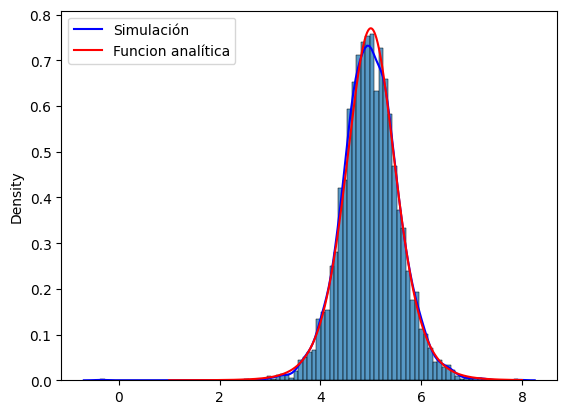

In [31]:
mu = 5
tau = 0.5
nu = 7

# Simulaciones
N = 4000

# Simulo Z
Z = rng.standard_t(nu,N)
# Transformo a X
X = Z*tau+mu

# Funcion analitica para chequear
tmodel = st.t(nu,loc=mu,scale=tau)
xi = np.array(range(1000,8000))/1000
ti = tmodel.pdf(xi)

## Grafico
sns.histplot(X,stat='density')
sns.kdeplot(X,label='Simulación',color='blue')
plt.plot(xi,ti,label='Funcion analítica',color='red')
plt.legend()
plt.show()